In [1]:
;cd "/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code/"

/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code


In [2]:
]activate learning_ds

In [3]:
include("plotting_utilities.jl")
include("ode_helper.jl")
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random

Loaded diff equations


In [4]:
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)


In [5]:
m = 1.
g = 1.
ℓ = 1.
k = 1.
α = g / ℓ

# vector field for the Elastic Pendulum
# q = x, p = m * ℓ^2 * ẋ
function hamiltonian(p, q)
    return m*g*ℓ * (1 - cos(q)) + p^2 / (2*m*ℓ^2)
end

function pendulum_true_vf(x, ẋ)
    return [ẋ, - g / ℓ * sin(x)]
end



intial_cdts = []
x0 = π/4
ẋ0 = 0.

initial_cdts = [(x0, ẋ0)]
T = 3.
num_samples = 5
x_t1, ẋ_t1 = solve_ode(pendulum_true_vf, [ x0, ẋ0]; verbose=true, tspan = (0., T), length=num_samples)

x0 = .9 * π
ẋ0 = 0.
x_t2 , ẋ_t2 = solve_ode(pendulum_true_vf, [x0, ẋ0]; verbose=true, tspan = (0., T), length=num_samples)
initial_cdts = [initial_cdts..., (x0, ẋ0)]

x_t = [x_t1..., x_t2...]
ẋ_t = [ẋ_t1..., ẋ_t2...]
ẍ_t = -g/ℓ * sin.(x_t)

#ẋ_t = randn(num_samples) * π
#x_t = randn(num_samples) * π
ε = 1e-2 
noise_t = (ε) -> randn(size(x_t, 1)) .* ε
#, x_t = 
size(x_t), size(noise_t(ε))

Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 12)
length = 5
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 11)
length = 5


((10,), (10,))

In [6]:
x_t

10-element Array{Float64,1}:
  0.7853981633974483
  0.5932715034691844
  0.1019358552799934
 -0.4427701805991178
 -0.7602638922267754
  2.827433388230814 
  2.7366024763643466
  2.4153266424847963
  1.7158678537930965
  0.4989094819117405

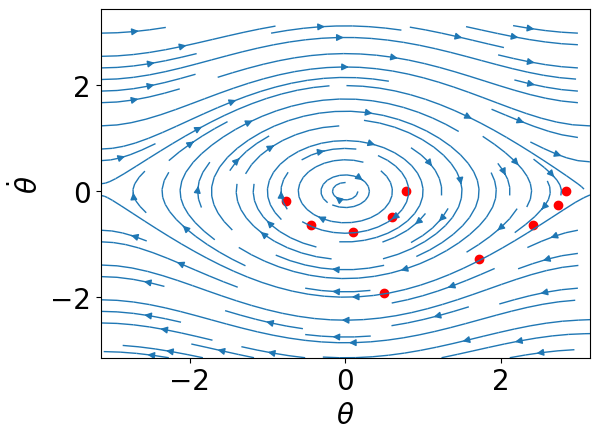

PyObject Text(44.472222222222214, 0.5, '$\\dot\\theta$')

In [7]:
pyplot(size = (400,400))
plot_vectorfield(pendulum_true_vf, (-π, π, 100), (-π, π, 100))
PyPlot.scatter(x_t, ẋ_t,  color=:red)
PyPlot.xlabel("\$\\theta\$")
PyPlot.ylabel("\$\\dot\\theta\$")

# Learn a polynomial vector field

<img src="polynomial_lagrangian.png">


In [8]:
@polyvar x y

function learn_polynomial_vf(x_t, ẋ_t, ẍ_t; 
        max_deg=6, sym=false, sign_constraints=false) 
    # q = x, p = m * ℓ^2 * ẋ
    monomials = [x^i * y^j for i=0:max_deg for j=0:max_deg if i+j <= max_deg]

    model = SOSModel(with_optimizer(Mosek.Optimizer, LOG=0))
    @variable model c[1:size(monomials, 1)]
    @variable model γ

    f = c' * monomials

    #@constraint H(1, 1)
    if sym
        @constraint model coefficients(f + f(x => -x, y => -y)) .== 0
    end
    if sign_constraints
        S = @set x >= 0
        @constraint model f <= 0 domain = S
        S = @set x <= 0
        @constraint model f >= 0 domain = S
    end
    
    error_term = ẍ_t  - f.(x_t, ẋ_t)
    @constraint model [γ, error_term...] in SecondOrderCone()
    @objective model Min γ
    optimize!(model)
    return value(γ) / size(error_term, 1), [y, value(f)]
end
                
function learn_hamiltonian_vf(x_t, ẋ_t, ẍ_t; 
                        max_deg=6, sym=false, sign_constraints=false)
    # y => ẋ
    max_deg = max_deg + 1
    monomials = [x^i * y^j for i=0:max_deg for j=0:max_deg if i+j < max_deg && i + j > 0]
    model = SOSModel(with_optimizer(Mosek.Optimizer, LOG=0))
    @variable model c[1:size(monomials, 1)]
    @variable model γ
    H = monomials' * c
    Hx = differentiate(H, x)
    Hy = differentiate(H, y)
    f = [Hy, -Hx]
    error_term = [
        (ẋ_t - f[1].(x_t, ẋ_t))...,
        (ẍ_t - f[2].(x_t, ẋ_t))...
    ]   

    @constraint model [γ, error_term...] in  SecondOrderCone()
    @objective model Min γ
                                    
    if sym
        @constraint model coefficients(H - H(x => x, y => -y)) .== 0
        @constraint model coefficients(H - H(x => -x, y => y)) .== 0
    end
    if sign_constraints
        S = @set x >= 0 && x <= 3.14
        @constraint model f[2] <= 0 domain = S
        S = @set x <= 0 && x >= -3.14
        @constraint model f[2] >= 0 domain = S
    end
    optimize!(model)
    
    return value(γ) / size(error_term, 1), value.(H), value.(f)
end

function compare_learned_vf_to_true_vf(f_value)
    learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
    figure(figsize=(10,5))
    subplot(121)
    learned_vf_plot = plot_vectorfield(learned_vf, (-π, π, 100), (-π, π, 100))
    PyPlot.scatter(x_t, ẋ_t, color=:red)
    PyPlot.xlabel("\$\\theta\$")
    PyPlot.ylabel("\$\\dot\\theta\$")

    subplot(122)
    true_vf_plot = plot_vectorfield(pendulum_true_vf, (-π, π, 100), (-π, π, 100))
    PyPlot.xlabel("\$\\theta\$")
    PyPlot.ylabel("\$\\dot\\theta\$")
end

compare_learned_vf_to_true_vf (generic function with 1 method)

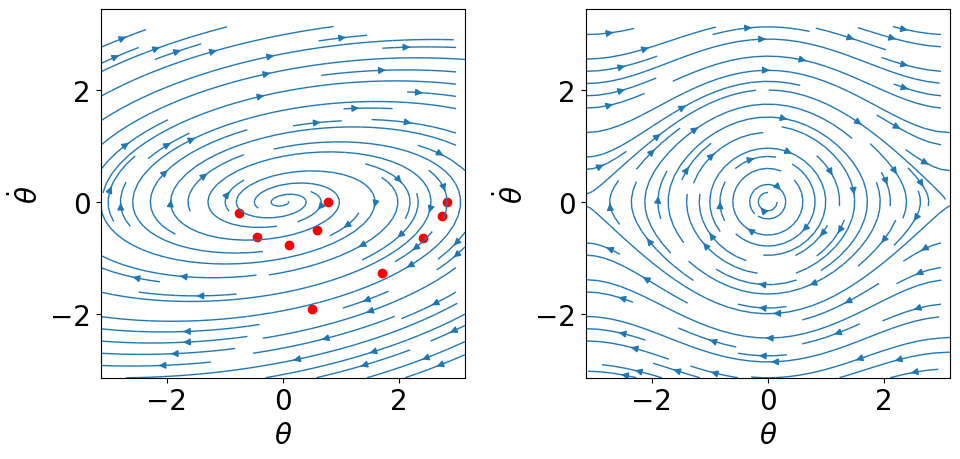

0.11447043737856552

In [9]:
ẍ_t = -g/ℓ * sin.(x_t)
ε = .1
Random.seed!(0)
error, f_value = learn_polynomial_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=2,
                                    sym=true,
                                    sign_constraints=false)
compare_learned_vf_to_true_vf(f_value)
error

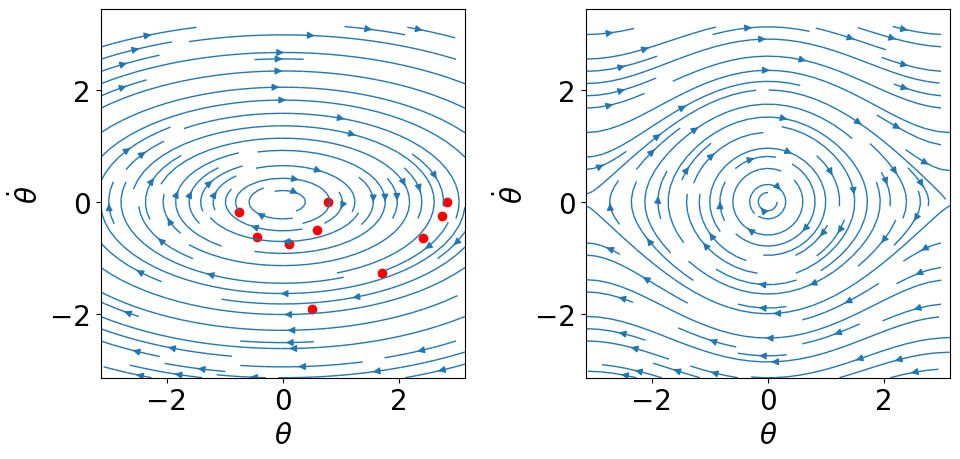

(0.06166429048763038, 0.13553277449692536x² + 0.5y²)

In [10]:
ε = 0.1
Random.seed!(0)
error, H_value, f_value = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=2,
                                    sym=true,
                                    sign_constraints=true)
compare_learned_vf_to_true_vf(f_value)
error, H_value

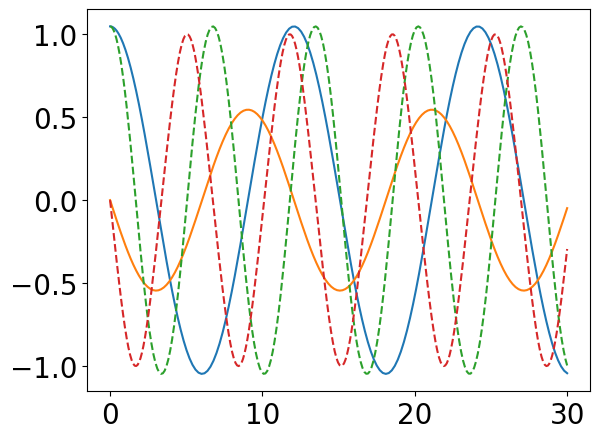

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1107029b38>
 PyObject <matplotlib.lines.Line2D object at 0x7f11070321d0>

In [11]:
learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
poly_vf(u, p, t) = learned_vf(u...)
true_vf(u, p, t) = pendulum_true_vf(u...)

T_eval = 10*T
u₀ = [π/3, 0.]

prob = ODEProblem(true_vf, u₀, (0., T_eval))
sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)


prob = ODEProblem(poly_vf, u₀, (0., T_eval))
poly_sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

pyplot()
PyPlot.figure()
PyPlot.plot(poly_sol.t, poly_sol.u)
PyPlot.plot(sol.t, sol.u, ls="dashed")

#Plots.plot!(learned_sol, vars=(7, 8), color=:red)


# Export data

In [10]:
# export real solution
using CSV
using DataFrames

In [80]:
function export_vf(vf, name;
        T_eval = 2*T, dt = .1, initial_cdts=initial_cdts)   
    ode_vf(u, p, t) = vf(u...)
    X_t = []
    t = collect(0:dt:T_eval)

    for u₀ in initial_cdts
        prob = ODEProblem(ode_vf, [u₀...], (0., T_eval))
        sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
        X_ti = hcat(sol.(t)...)
        X_t = [X_t..., X_ti]
        
    end
    df = DataFrame(t=t, theta1=X_t[1][1,:], theta_dot1=X_t[1][2,:],
                   theta2=X_t[2][1,:], theta_dot2=X_t[2][2,:])
    CSV.write("pendulum/trajectory_simple_pendulum_$name.csv", df)
    
    # export vf
    PyPlot.figure()
    M = 1.3*π
    my_streamplot, segments, arrows = latex_vectorfield(vf, 
        (-M, M, 100), (-M, M, 100))
    CSV.write("pendulum/segments_$name.csv", round.(segments, digits=5))
    CSV.write("pendulum/arrows_$name.csv", round.(arrows, digits=5))
    
    
end

function export_solution(f_as_poly, opt_value, name; H_as_poly=0)
    open("pendulum/polynomial_solution_$name.poly", "w") do f
        print()
        for i=1:2
            write(f, latexstring(f_as_poly[i]))
            write(f, "\n")
        end
        write(f, "opt_value = " * string(opt_value))
        write(f, "\n")
        write(f, "H_as_poly = " * string(H_as_poly))
        write(f, "\n")
    end
end



export_solution (generic function with 1 method)

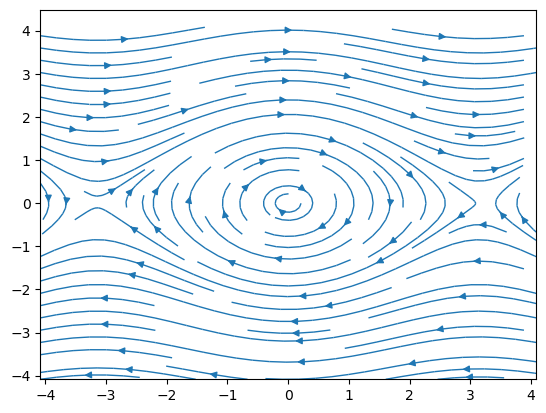

"pendulum/arrows_true_vf.csv"

In [12]:
name = "true_vf"
export_vf(pendulum_true_vf, name; 
    T_eval = 10*T, dt = .1, initial_cdts=initial_cdts)   


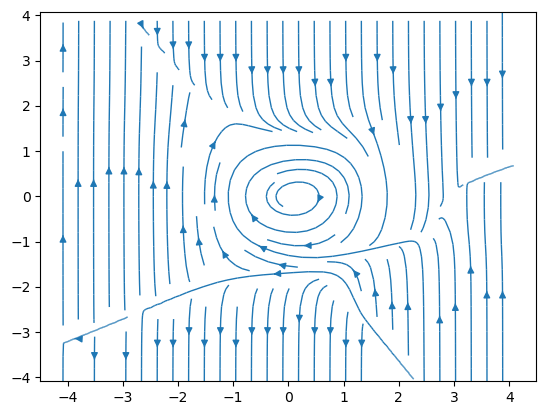

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(6) of matrix 'A'.


1

In [13]:
# no side info
Random.seed!(0)
name = "poly_vf"
opt_value, f_as_poly = learn_polynomial_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=false,
                                    sign_constraints=false)
vf(xv, yv) = [  f_as_poly[1](x=>xv, y=>yv), f_as_poly[2](x=>xv, y=>yv) ]

export_vf(vf, name;T_eval = 10*T, dt = .1, initial_cdts=initial_cdts)   
export_solution(f_as_poly, opt_value, name)

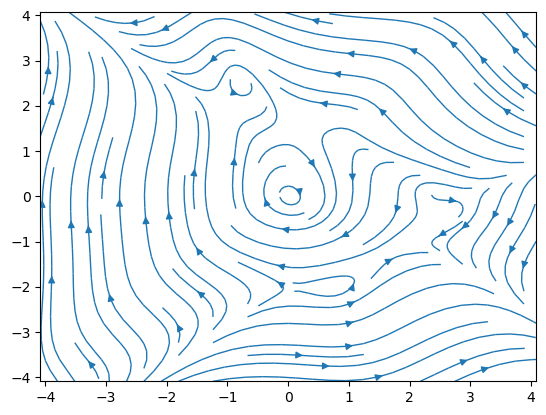

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.


1

In [14]:
# hamiltonian
Random.seed!(0)
name = "hamiltonian_vf"
opt_value, H_as_poly, f_as_poly = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=false,
                                    sign_constraints=false)

vf(xv, yv) = [  f_as_poly[1](x=>xv, y=>yv), 
                f_as_poly[2](x=>xv, y=>yv) ]

export_vf(vf, name;T_eval = .1*T, dt = .1, initial_cdts=initial_cdts)   
export_solution(f_as_poly, opt_value, name; H_as_poly=H_as_poly)

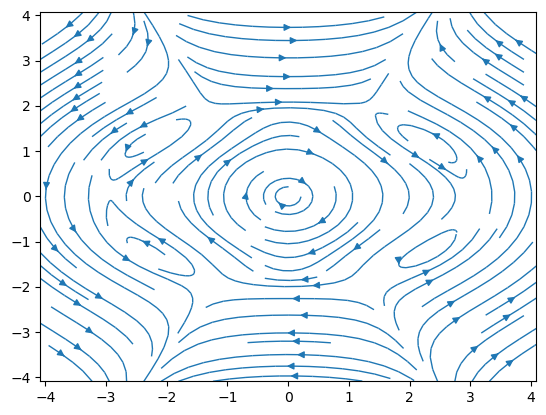

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(56) of matrix 'A'.


1

In [15]:
# hamiltonian + sym
Random.seed!(0)
name = "hamiltonian_sym_vf"
opt_value, H_as_poly, f_as_poly = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=true,
                                    sign_constraints=false)

vf(xv, yv) = [  f_as_poly[1](x=>xv, y=>yv), 
                f_as_poly[2](x=>xv, y=>yv) ]

export_vf(vf, name;T_eval = .1*T, dt = .1, initial_cdts=initial_cdts)   
export_solution(f_as_poly, opt_value, name; H_as_poly=H_as_poly)

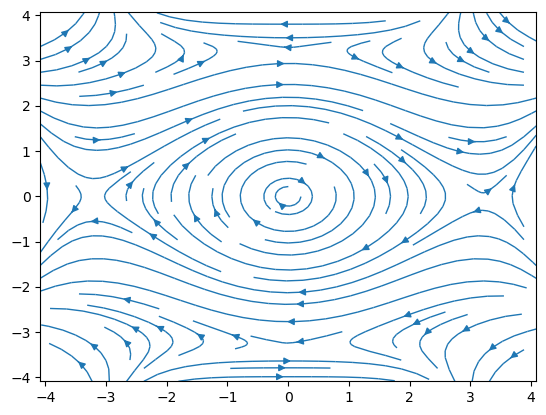

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(56) of matrix 'A'.


1

In [16]:
# hamiltonian + sym + pos
Random.seed!(0)
name = "hamiltonian_sym_pos_vf"
opt_value, H_as_poly, f_as_poly = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=true,
                                    sign_constraints=true)

vf(xv, yv) = [  f_as_poly[1](x=>xv, y=>yv), 
                f_as_poly[2](x=>xv, y=>yv) ]

export_vf(vf, name;T_eval = 10*T, dt = .1, initial_cdts=initial_cdts)   
export_solution(f_as_poly, opt_value, name; H_as_poly=H_as_poly)

In [17]:
macro bash_str(s) open(`bash`,"w",stdout) do io; print(io, s); end; end

@bash_str (macro with 1 method)

In [18]:
bash"""
cp ~/Dropbox/AAA_Bachir/Learning_with_side_information/Code/pendulum/*{poly,csv} ~/Dropbox/AAA_Bachir/Learning_with_side_information/Drafts/Learning_with_side_information_v1/data/pendulum/
"""

# AAA Slides

In [12]:
function prepare_plot()
    PyPlot.figure(figsize=(7, 5))
    PyPlot.xticks([-π, π], ["-\$\\pi\$", "\$\\pi\$"])
    PyPlot.yticks([-π, π], ["-\$\\pi\$", "\$\\pi\$"])
end

prepare_plot (generic function with 1 method)

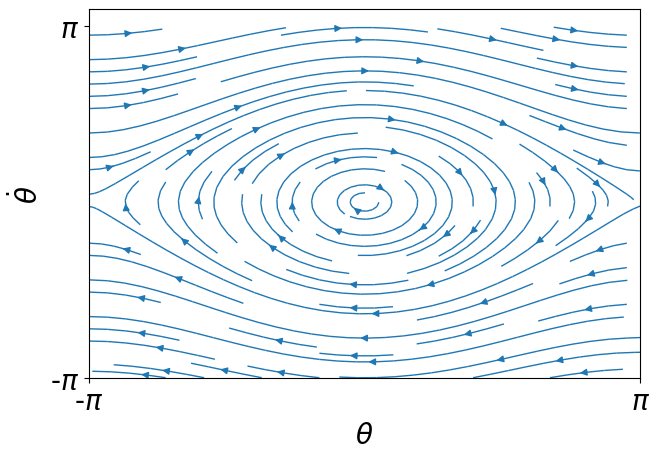

PyObject Text(44.472222222222214, 0.5, '$\\dot\\theta$')

In [13]:
function plot_poly_vf(f_value)
    learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
    prepare_plot()
    #subplot(121)
    learned_vf_plot = plot_vectorfield(learned_vf, (-π, π, 100), (-π, π, 100))
    PyPlot.xlabel("\$\\theta\$")
    PyPlot.ylabel("\$\\dot\\theta\$")
end

function plot_data()
    for X0 in initial_cdts
        x_ti, ẋ_ti = solve_ode(pendulum_true_vf, [X0...];
            verbose=true, tspan = (0., T), length=100)
        PyPlot.plot(x_ti, ẋ_ti, color=:red)
    end    
end

#pyplot(size = (200,200))
prepare_plot()


plot_vectorfield(pendulum_true_vf, (-π, π, 100), (-π, π, 100))
ε = .5
Random.seed!(0)
all_noise = [noise_t(ε) for _ in 1:3]
#PyPlot.scatter(x_t, ẋ_t,  color=:red)
PyPlot.xlabel("\$\\theta\$")
PyPlot.ylabel("\$\\dot\\theta\$")

In [14]:
function plot_data_from_poly_vf(f_value)
    learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
    for X0 in initial_cdts
        x_ti, ẋ_ti = solve_ode(learned_vf, [X0...];
            verbose=true, tspan = (0., T), length=100)
        PyPlot.plot(x_ti, ẋ_ti, color=:black)
    end    
end

plot_data_from_poly_vf (generic function with 1 method)

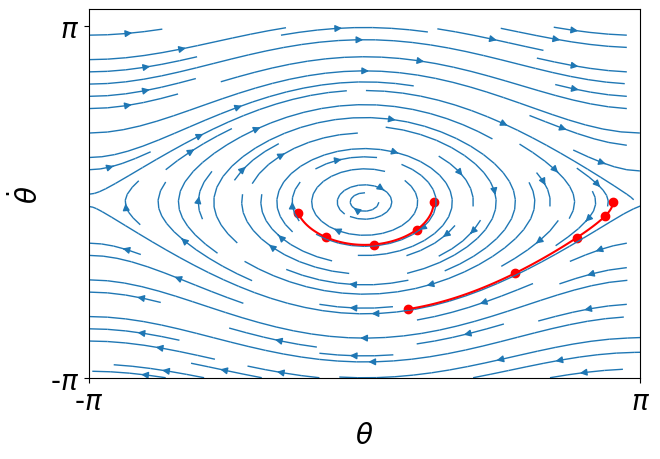

Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 12)
length = 100
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 11)
length = 100


PyObject Text(44.472222222222214, 0.5, '$\\dot\\theta$')

In [15]:
prepare_plot()
plot_vectorfield(pendulum_true_vf, (-π, π, 100), (-π, π, 100))
PyPlot.scatter(x_t, ẋ_t,  color=:red)
plot_data()
PyPlot.xlabel("\$\\theta\$")
PyPlot.ylabel("\$\\dot\\theta\$")


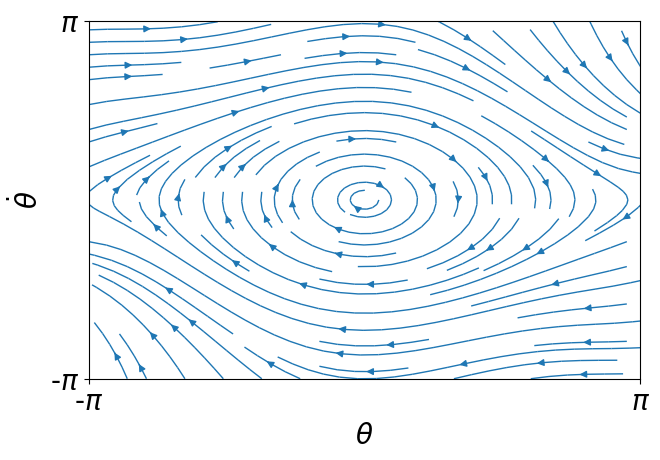

PyObject Text(44.472222222222214, 0.5, '$\\dot\\theta$')

In [16]:
ε = .2
Random.seed!(0)
error, f_value = learn_polynomial_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=6,
                                    sym=true,
                                    sign_constraints=true)
plot_poly_vf(f_value)

In [17]:
function plot_data_from_poly_vf(f_value, T_max=T)
    learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
    normalized_vf(xv, yv) = learned_vf(xv, yv)# / sqrt(xv^2 + yv^2)
    # normalize
    for X0 in initial_cdts
        x_ti, ẋ_ti = solve_ode(normalized_vf, [X0...];
            verbose=true, tspan = (0., T_max), length=100)
        PyPlot.plot(x_ti, ẋ_ti, color=:black)
    end    
end

plot_data_from_poly_vf(f_value)
plot_vectorfield(f_value)

Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 12)
length = 100
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 11)
length = 100


MethodError: MethodError: no method matching plot_vectorfield(::Array{Polynomial{true,Float64},1})
Closest candidates are:
  plot_vectorfield(::Any, !Matched::Any, !Matched::Any) at /home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code/plotting_utilities.jl:6

Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 13)
length = 100
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 16)
length = 100
Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 12)
length = 100
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 11)
length = 100
-----------------------------
deg_5_sym_false_sign_false_hamiltonian_false
y
0.09157380593563796*x^5 - 0.08894011621545996*x^4*y - 0.29087656535670714*x^3*y^2 - 0.3063930632229929*x^2*y^3 + 0.04620475363378977*x*y^4 - 0.20288197867674704*y^5 - 0.4074151501319298*x^4 + 0.28882885990763313*x^3*y + 0.5598538268228737*x^2*y^2 + 0.47682118473095497*x*y^3 - 0.16149094582978576*y^4 + 0.28965101503834767*x^3 - 1.2013240096631939*x^2*y - 1.1907538202337717*x*y^2 + 0.16919663357993095*y^3 + 0.5712080064897554*x^2 + 2.0384386226545597*x*y + 0.4621880196159592*y^2 - 0.6867948764494329*x - 1.7645675851138998*y - 0.8071075736040657
-----------------------------
Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 13)
length = 100
S

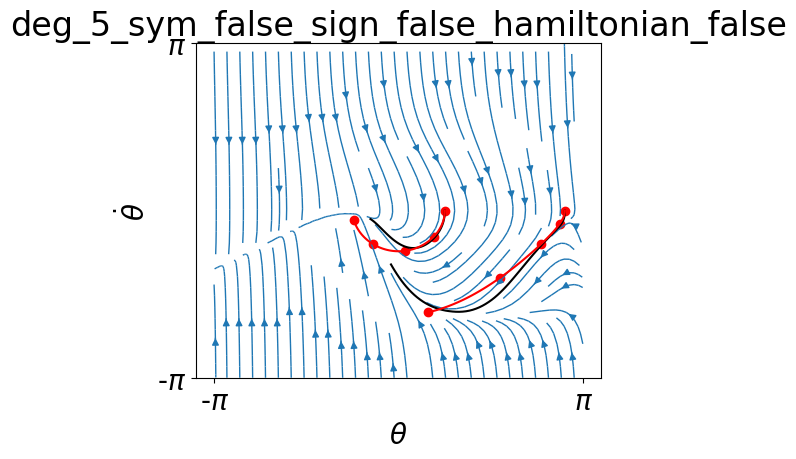

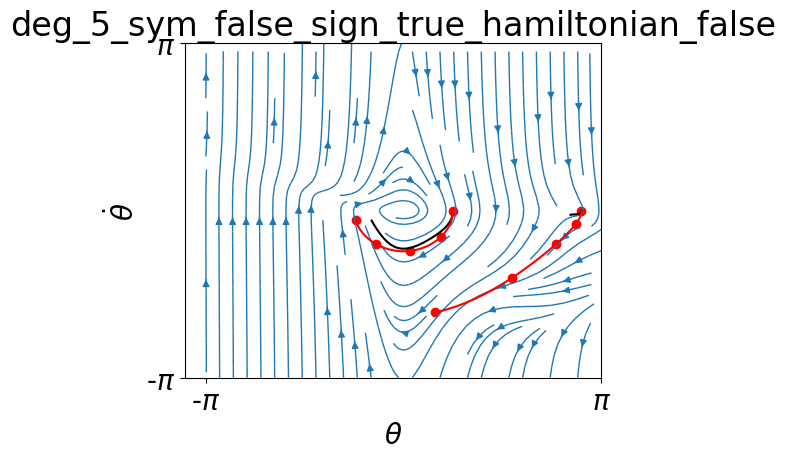

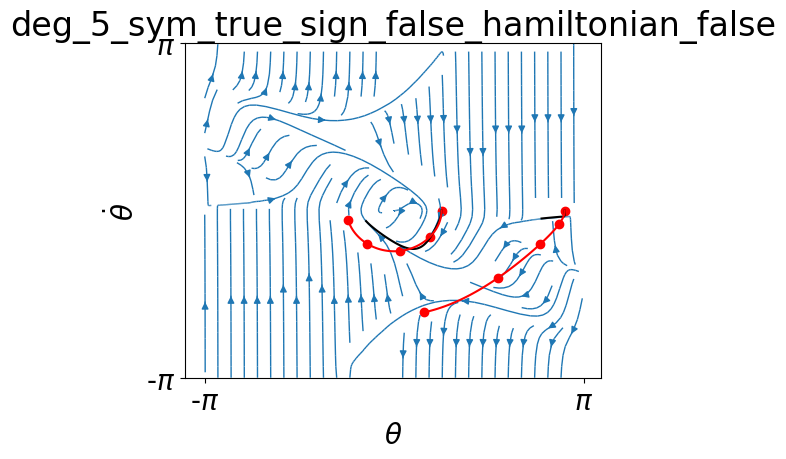

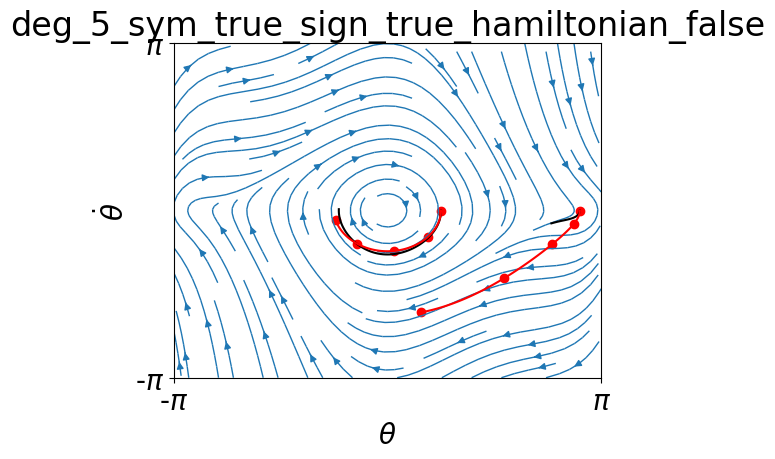

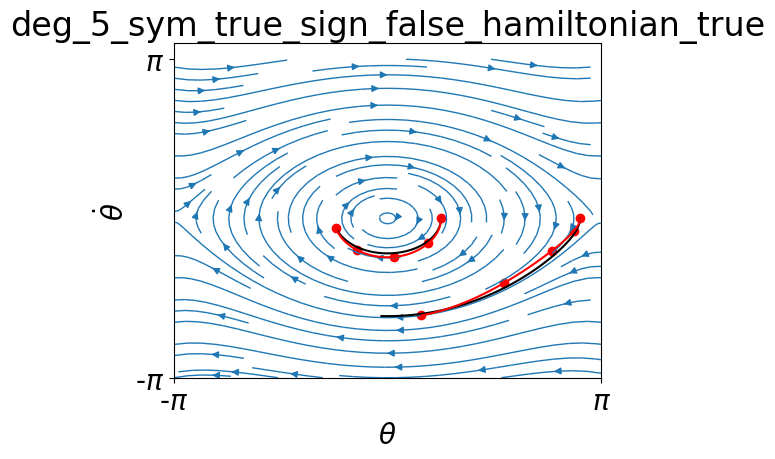

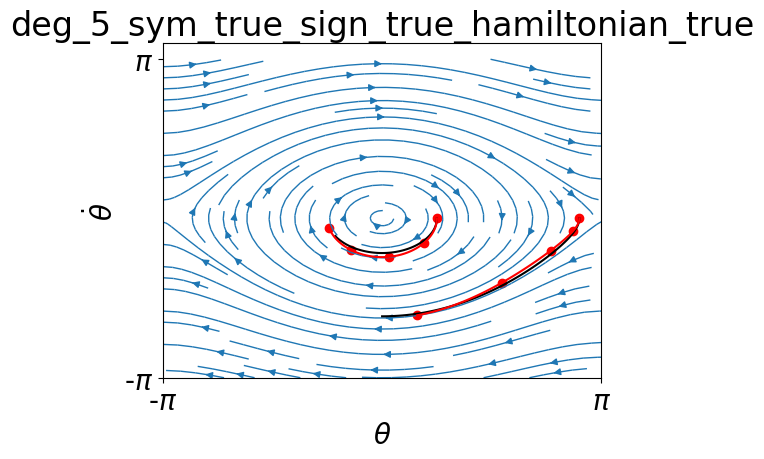

Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 11)
length = 100
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 12)
length = 100
Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 12)
length = 100
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 11)
length = 100
-----------------------------
deg_5_sym_true_sign_true_hamiltonian_true
-4.732461253700251e-8*x^2*y + 6.280861442326785e-9*y^3 + 1.0000001781382681*y
0.07961668020763923*x^3 + 4.732461253700251e-8*x*y^2 - 0.784988714317034*x
-----------------------------


In [27]:
simulations_paramters = []
degs = [5]


for is_hamilitonian in [false, true]
for max_deg in degs
for sym = [false, true]
for sign = [false, true]
                if is_hamilitonian && !sym
                    continue
                end
    simulations_paramters = [simulations_paramters...,
    Dict([:max_deg => max_deg, :sym => sym, :sign_constraints => sign,
    :is_hamiltonian => is_hamilitonian,
    :name => "deg_$(max_deg)_sym_$(sym)_sign_$(sign)_hamiltonian_$(is_hamilitonian)"])
    ]
end                
end
end
end

for p in simulations_paramters
    name = p[:name]
    learning_function = learn_polynomial_vf
    if p[:is_hamiltonian] 
        learning_function = learn_hamiltonian_vf
    end
    f_value = learning_function(x_t.+ all_noise[1], 
                          ẋ_t.+ all_noise[2], 
                          ẍ_t.+ all_noise[3],
                        max_deg = p[:max_deg],
                        sym=p[:sym],
        sign_constraints=p[:sign_constraints])[end]
    plot_poly_vf(f_value)
    plot_data_from_poly_vf(f_value)
    plot_data()    
    PyPlot.scatter(x_t, ẋ_t, color=:red)
    plt.title(name)
    println("-----------------------------")
    println(name)
    println(f_value[1])
    println(f_value[2])
    println("-----------------------------")

    #PyPlot.savefig("$(path)/$(name).png", bbox_inches = "tight")
    # title(name)
end

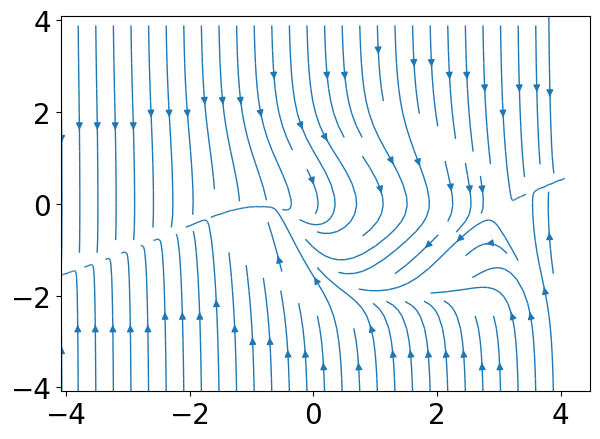

"pendulum/arrows_vf_no_side_info.csv"

In [101]:
p = simulations_paramters[1]
learning_function = learn_polynomial_vf
vf_no_side_info = learning_function(x_t.+ all_noise[1], 
                          ẋ_t.+ all_noise[2], 
                          ẍ_t.+ all_noise[3],
                        max_deg = p[:max_deg],
                        sym=p[:sym],
        sign_constraints=p[:sign_constraints])[end]
vf(xv, yv) = [  vf_no_side_info[1](x=>xv, y=>yv), vf_no_side_info[2](x=>xv, y=>yv) ]
export_vf(vf, "vf_no_side_info", T_eval=20)


Dict{Symbol,Any}(:sign_constraints=>true,:sym=>true,:name=>"deg_5_sym_true_sign_true_hamiltonian_true",:max_deg=>5,:is_hamiltonian=>true)Solving ODE from x0=[0.785398, 0.0]

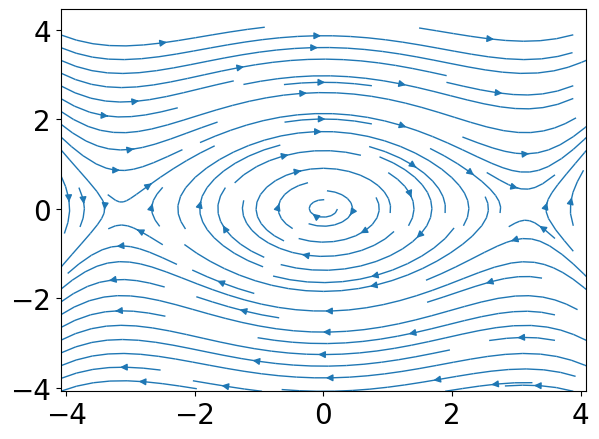

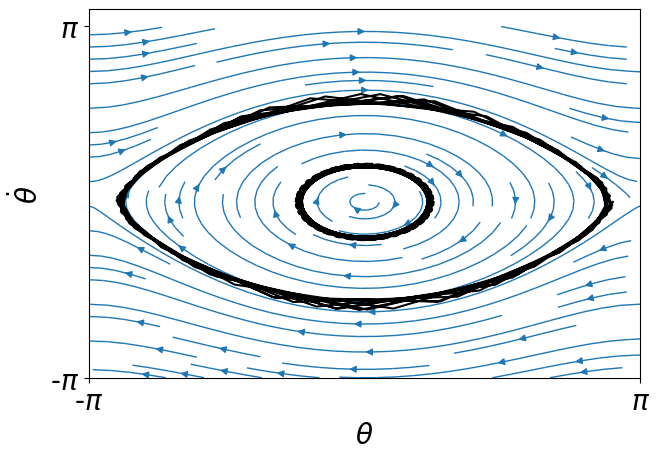


size(sol) = (2, 111)
length = 100
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 120)
length = 100


In [105]:
p = simulations_paramters[end]
print(p)
learning_function = learn_hamiltonian_vf
vf_all_side_info = learning_function(x_t.+ all_noise[1], 
                          ẋ_t.+ all_noise[2], 
                          ẍ_t.+ all_noise[3],
                        max_deg = p[:max_deg],
                        sym=p[:sym],
        sign_constraints=p[:sign_constraints])[end]
vf(xv, yv) = [  vf_all_side_info[1](x=>xv, y=>yv), vf_all_side_info[2](x=>xv, y=>yv) ]
export_vf(vf, "vf_all_side_info", T_eval=20)
plot_poly_vf(vf_all_side_info)
plot_data_from_poly_vf(vf_all_side_info, 100)

In [103]:
p

Dict{Symbol,Any} with 5 entries:
  :sign_constraints => true
  :sym              => true
  :name             => "deg_5_sym_true_sign_true_hamiltonian_true"
  :max_deg          => 5
  :is_hamiltonian   => true

In [106]:
function export_trajectory(f_value, name; T_eval=50)
    learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
    print(learned_vf(10, 10))
    length=100
    dt = T_eval/(length-1)
    t = collect(0:dt:T_eval)
    X0 = (0.7853981633974483, 0.0)
    x_ti, ẋ_ti = solve_ode(learned_vf, [X0...];
        verbose=true, tspan = (0., T_eval), length=length)
    df = DataFrame(t=t, theta=x_ti, theta_dot=ẋ_ti)    
    CSV.write("pendulum/trajectory_simple_pendulum_$name.csv", df)
    #return x_ti
end
export_trajectory(vf_all_side_info, "vf_all_side_info")
export_trajectory(vf_no_side_info, "vf_no_side_info")



[9.99996, 71.7668]Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 61)
length = 100
[10.0, -69216.7]Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 170)
length = 100


"pendulum/trajectory_simple_pendulum_vf_no_side_info.csv"

In [98]:
vf_all_side_info[1] + x

-4.732461253700251e-8x²y + 6.280861442326785e-9y³ + x + 1.0000001781382681y

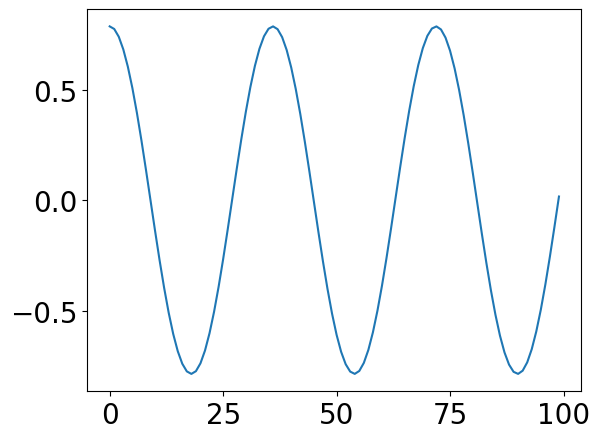

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f634926db00>

In [93]:
PyPlot.plot(x_ti)

In [96]:
ẋ, - g / ℓ * sin(x)

MethodError: MethodError: no method matching sin(::PolyVar{true})
Closest candidates are:
  sin(!Matched::Float16) at math.jl:1018
  sin(!Matched::Complex{Float16}) at math.jl:1019
  sin(!Matched::Missing) at math.jl:1070
  ...